In [27]:
import numpy as np
import os
import sys
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import json
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import seaborn as sns
from matplotlib import pyplot as plt
import datasets

#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
MODEL_NAME = 'HuggingFaceTB/SmolLM-360M'
DEVICE = 'cuda'
NUM_CHECKPOINTS = 20
EVALSET_LEN = 50

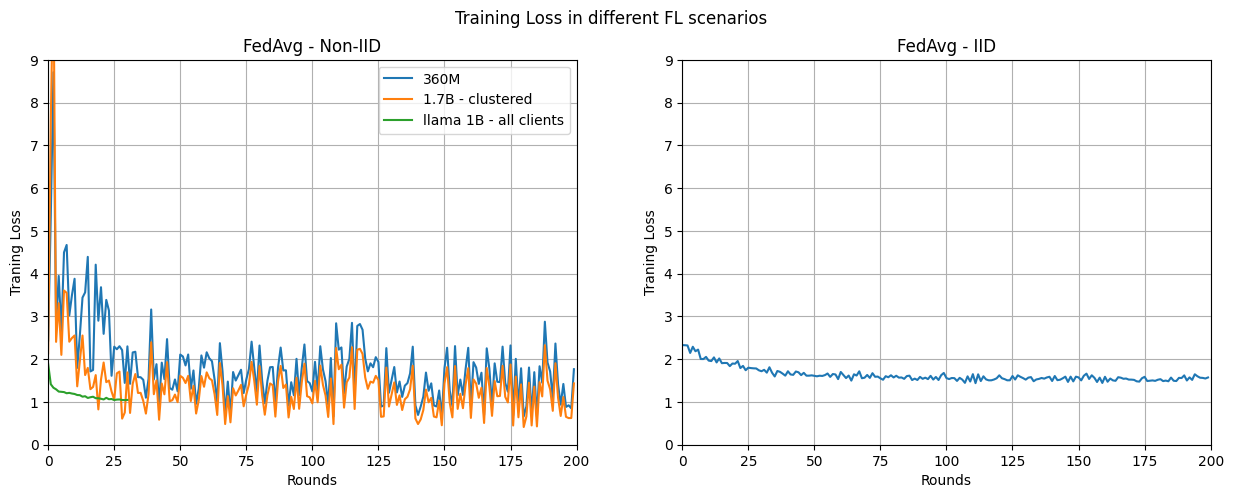

In [28]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/multitask_400000_clustered_c20s2_i10_b16a1_l1024_r8a16_20250324093735/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/multitask_400000_clustered_c20s2_i10_b16a1_l1024_r8a16_20250324095052/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/multitask_400000_clustered_c20s2_i10_b16a1_l1024_r8a16_20250324120625/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses3 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses3.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/unsloth/Llama-3.2-1B/testing_llama_fedavg_selecting_all_multitask_clustered_c20s20_i10_b16a1_l1024_r8a16_20250331115952/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses4 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses4.append(loss)

#subplots 

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

sns.lineplot(x=range(len(losses)), y=losses, ax=ax[0], label='360M')
sns.lineplot(x=range(len(losses3)), y=losses3, ax=ax[0], label = '1.7B - clustered')
sns.lineplot(x=range(len(losses4)), y=losses4, ax=ax[0], label = 'llama 1B - all clients')
sns.lineplot(x=range(len(losses2)), y=losses2, ax=ax[1])

#set overall title
fig.suptitle('Training Loss in different FL scenarios')

ax[0].set_title('FedAvg - Non-IID')
ax[0].set_xlabel('Rounds')
ax[0].set_ylabel('Traning Loss')
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0, 9)
ax[0].grid(True)

ax[1].set_title('FedAvg - IID')
ax[1].set_xlabel('Rounds')
ax[1].set_ylabel('Traning Loss')
ax[1].set_xlim(0, 200)
ax[1].set_ylim(0, 9)
ax[1].grid(True)


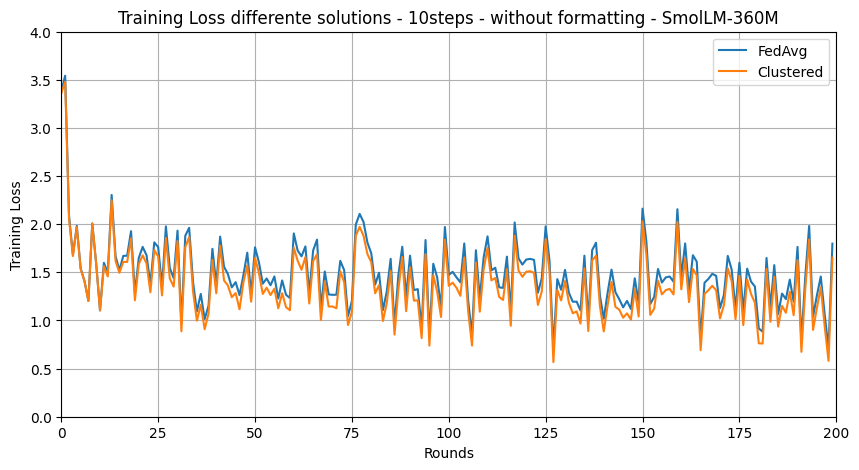

In [29]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-360M/wo_formatting_fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331161819/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-360M/wo_formatting_clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331134834/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

# Add trend lines using linear regression
x_vals = np.arange(len(losses))

colors = sns.color_palette()

#z_fedavg = np.polyfit(x_vals, losses, 1)
#trend_fedavg = np.poly1d(z_fedavg)(x_vals)
#plt.plot(x_vals, trend_fedavg, linestyle='--', color=colors[0], label='FedAvg Trend')
#z_clustered = np.polyfit(x_vals, losses2, 1)
#trend_clustered = np.poly1d(z_clustered)(x_vals)
#plt.plot(x_vals, trend_clustered, linestyle='--', color=colors[1], label='Clustered Trend')

plt.title('Training Loss differente solutions - 10steps - without formatting - SmolLM-360M')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

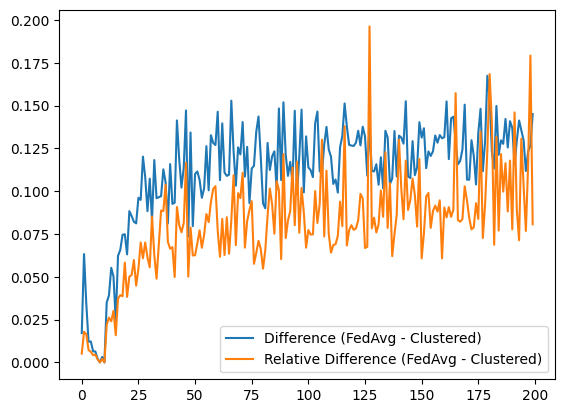

In [30]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/1587447648.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1587447648.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmea

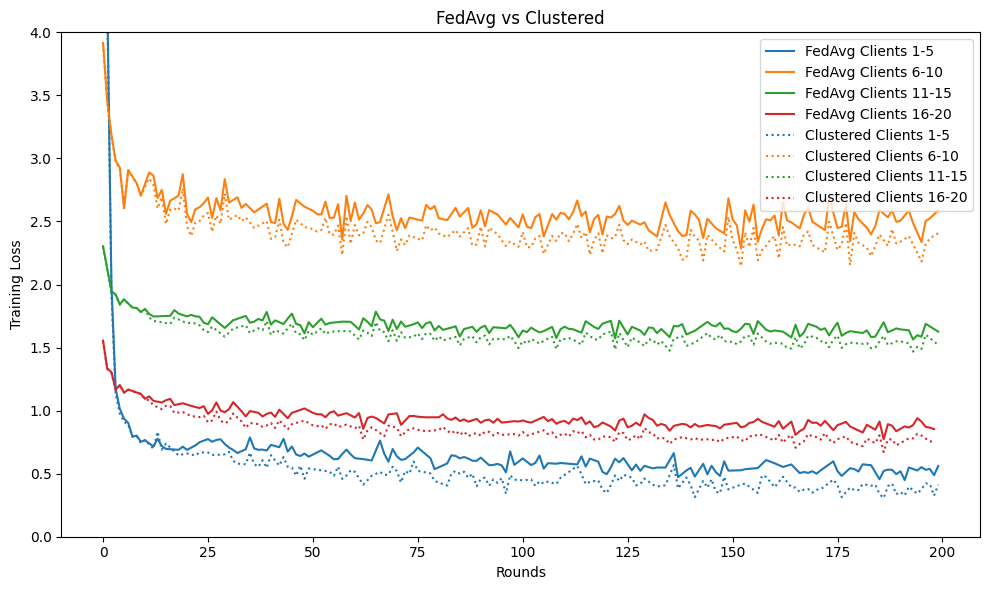

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the 4 groups
colors = sns.color_palette("tab10", 4)

# FedAvg lines (solid)
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-360M/wo_formatting_fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331161819/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)
rounds_fedavg = np.arange(data_fedavg.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_fedavg[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_fedavg, y=mean_line, ax=ax,
                 label=f'FedAvg Clients {start+1}-{start+5}', linestyle='solid', color=colors[i])

# Clustered lines (dotted) with the same color for the same group
clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-360M/wo_formatting_clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331134834/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)
rounds_clustered = np.arange(data_clustered.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_clustered[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_clustered, y=mean_line, ax=ax,
                 label=f'Clustered Clients {start+1}-{start+5}', linestyle='dotted', color=colors[i])

ax.set_title('FedAvg vs Clustered')
ax.set_xlabel('Rounds')
ax.set_ylabel('Training Loss')
ax.set_ylim(0, 4)
plt.tight_layout()


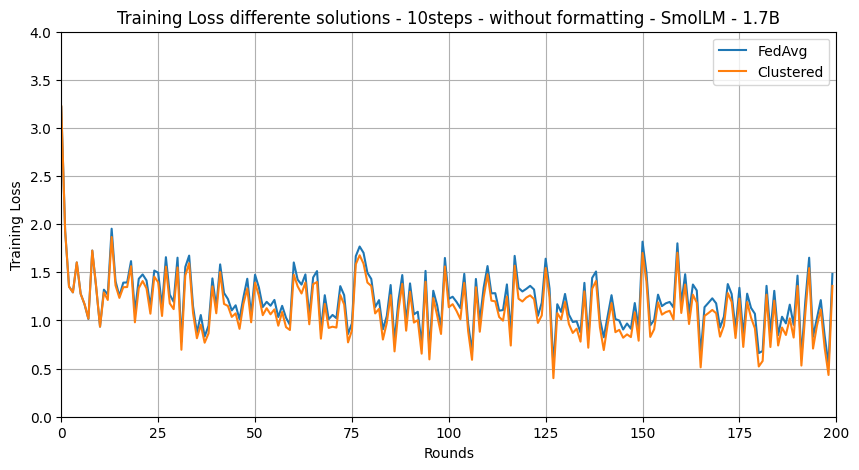

In [32]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-1.7B/multitask_fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401094245/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-1.7B/multitask_clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401094408/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

# Set overall title
plt.title('Training Loss differente solutions - 10steps - without formatting - SmolLM - 1.7B')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

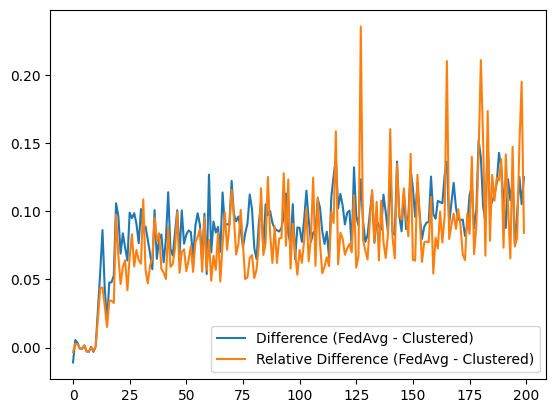

In [33]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/1707562816.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/1707562816.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmea

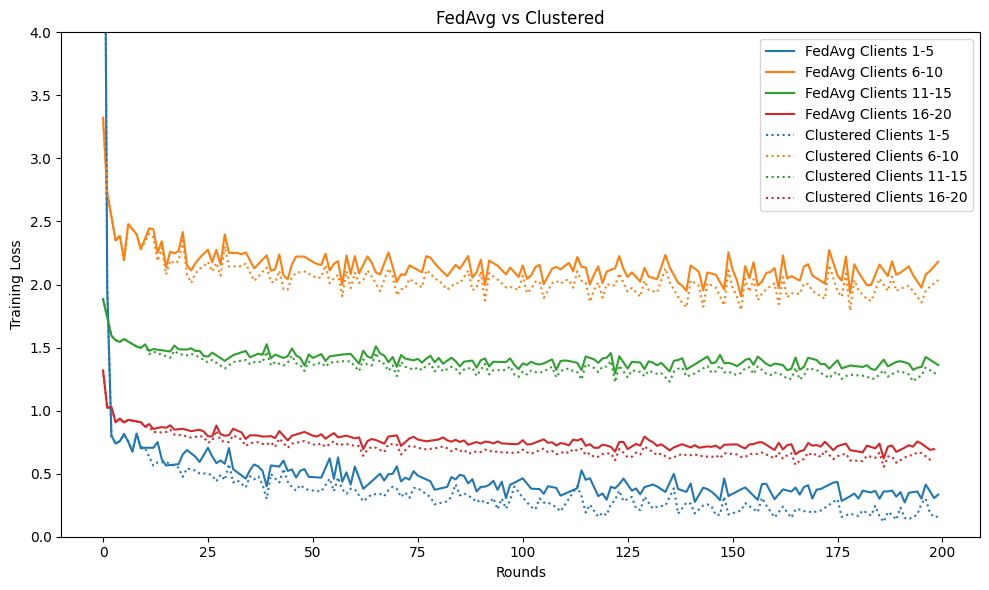

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the 4 groups
colors = sns.color_palette("tab10", 4)

# FedAvg lines (solid)
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-1.7B/multitask_fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401094245/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)
rounds_fedavg = np.arange(data_fedavg.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_fedavg[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_fedavg, y=mean_line, ax=ax,
                 label=f'FedAvg Clients {start+1}-{start+5}', linestyle='solid', color=colors[i])

# Clustered lines (dotted) with the same color for the same group
clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/SmolLM-1.7B/multitask_clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401094408/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)
rounds_clustered = np.arange(data_clustered.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_clustered[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_clustered, y=mean_line, ax=ax,
                 label=f'Clustered Clients {start+1}-{start+5}', linestyle='dotted', color=colors[i])

ax.set_title('FedAvg vs Clustered')
ax.set_xlabel('Rounds')
ax.set_ylabel('Training Loss')
ax.set_ylim(0, 4)
plt.tight_layout()


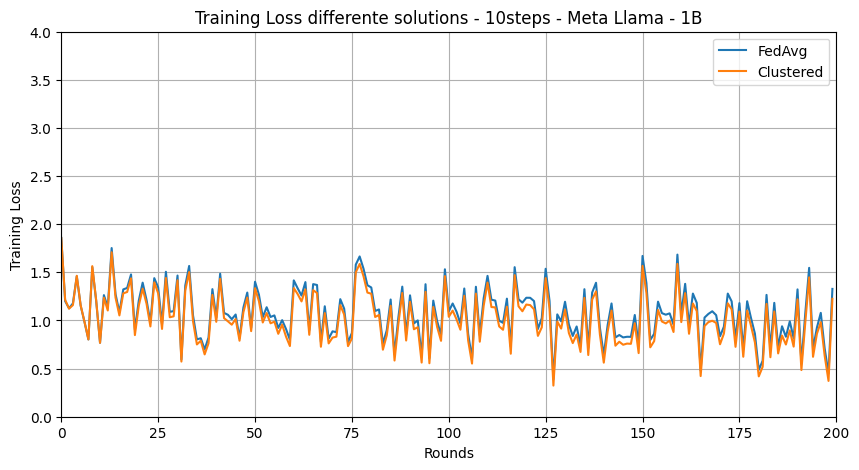

In [35]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401152254/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401151553/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

# Set overall title
plt.title('Training Loss differente solutions - 10steps - Meta Llama - 1B')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

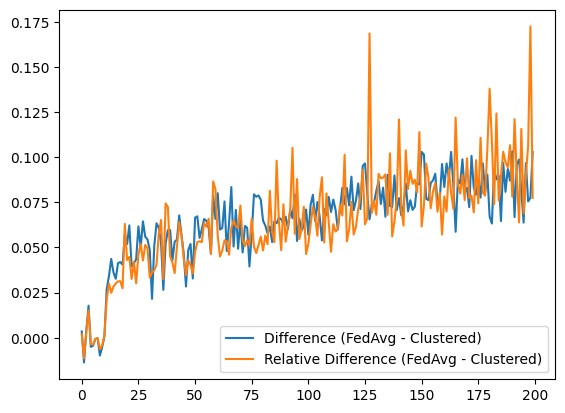

In [36]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/3471706126.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:12: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3471706126.py:22: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmea

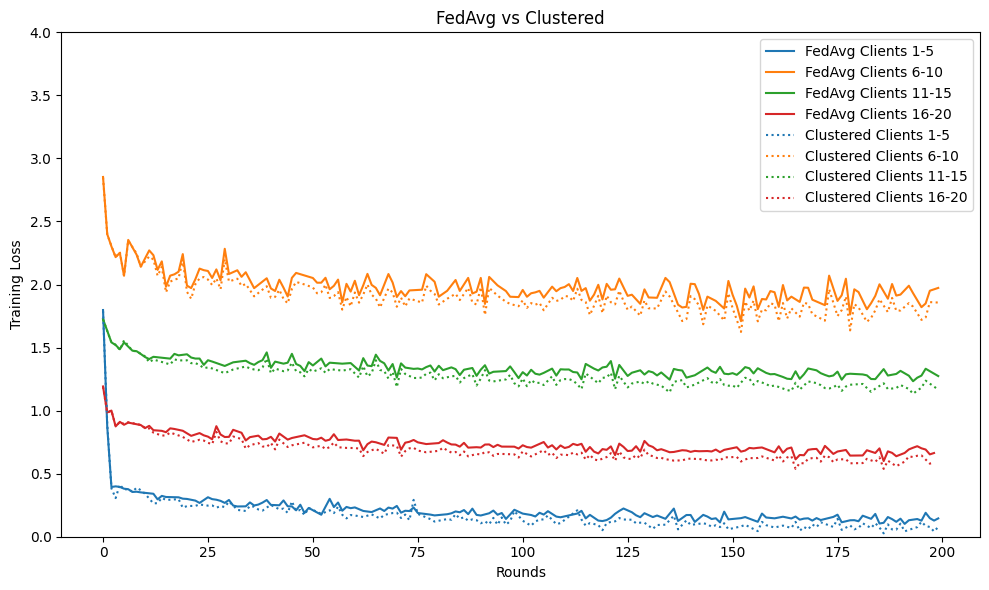

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the 4 groups
colors = sns.color_palette("tab10", 4)

# FedAvg lines (solid)
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401152254/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)
rounds_fedavg = np.arange(data_fedavg.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_fedavg[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_fedavg, y=mean_line, ax=ax,
                 label=f'FedAvg Clients {start+1}-{start+5}', linestyle='solid', color=colors[i])

# Clustered lines (dotted) with the same color for the same group
clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401151553/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)
rounds_clustered = np.arange(data_clustered.shape[1])
for i, start in enumerate(range(0, 20, 5)):
    subset = data_clustered[start:start+5, :]
    mean_line = np.nanmean(np.where(subset != -1, subset, np.nan), axis=0)
    sns.lineplot(x=rounds_clustered, y=mean_line, ax=ax,
                 label=f'Clustered Clients {start+1}-{start+5}', linestyle='dotted', color=colors[i])

ax.set_title('FedAvg vs Clustered')
ax.set_xlabel('Rounds')
ax.set_ylabel('Training Loss')
ax.set_ylim(0, 4)
plt.tight_layout()


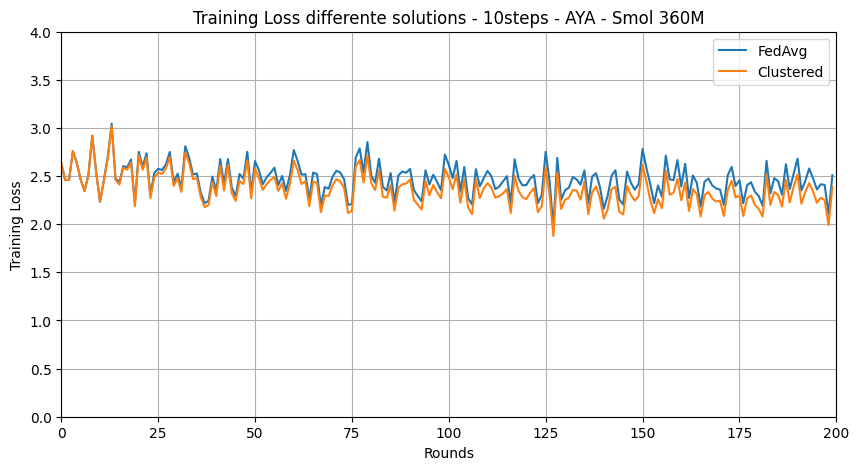

In [38]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-360M/aya_fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331143830/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-360M/aya_clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331143605/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

#z_fedavg = np.polyfit(x_vals, losses, 1)
#trend_fedavg = np.poly1d(z_fedavg)(x_vals)
#plt.plot(x_vals, trend_fedavg, linestyle='--', color=colors[0], label='FedAvg Trend')
#z_clustered = np.polyfit(x_vals, losses2, 1)
#trend_clustered = np.poly1d(z_clustered)(x_vals)
#plt.plot(x_vals, trend_clustered, linestyle='--', color=colors[1], label='Clustered Trend')

# Set overall title
plt.title('Training Loss differente solutions - 10steps - AYA - Smol 360M')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

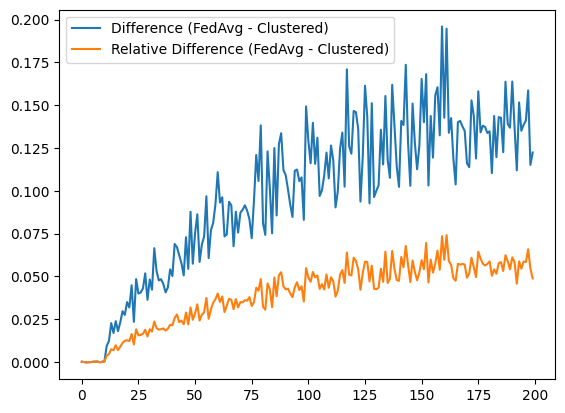

In [39]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/3711644909.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3711644909.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3711644909.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3711644909.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3711644909.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3711644909.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_su

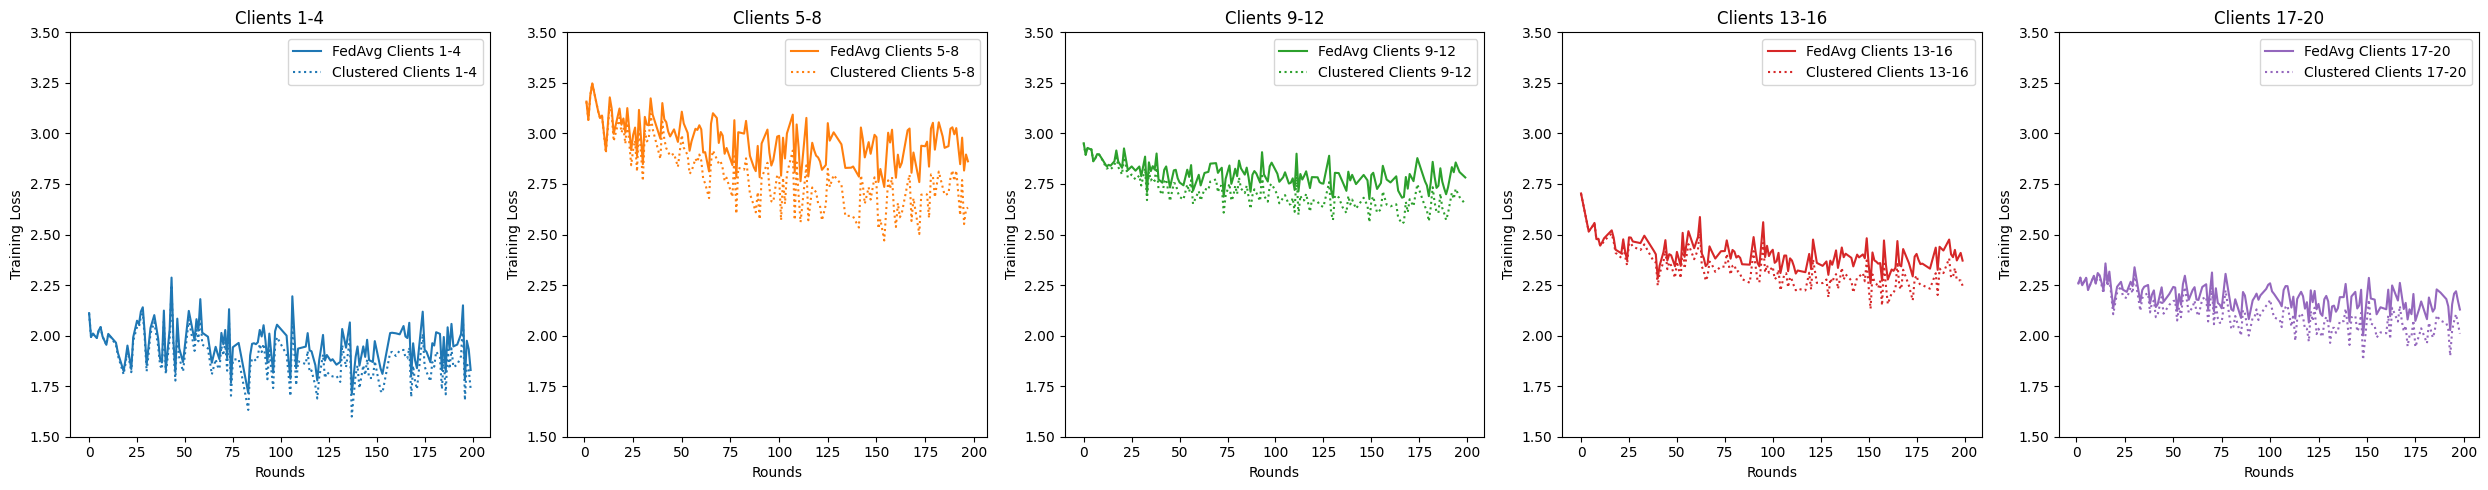

In [40]:
colors = sns.color_palette("tab10", 5)

# Load AYA data for FedAvg and Clustered solutions
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-360M/aya_fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331143830/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)

clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-360M/aya_clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250331143605/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)

rounds = np.arange(data_fedavg.shape[1])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes):
    start = i * 4
    fedavg_subset = data_fedavg[start:start+4, :]
    clustered_subset = data_clustered[start:start+4, :]
    fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
    clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
    
    # Plot FedAvg (solid) and Clustered (dotted) in the same subplot
    sns.lineplot(x=rounds, y=fedavg_mean, ax=ax, label=f'FedAvg Clients {start+1}-{start+4}',
                 color=colors[i], linestyle='solid')
    sns.lineplot(x=rounds, y=clustered_mean, ax=ax, label=f'Clustered Clients {start+1}-{start+4}',
                 color=colors[i], linestyle='dotted')
    
    ax.set_title(f'Clients {start+1}-{start+4}')
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Training Loss')
    ax.set_ylim(1.5, 3.5)
    ax.legend()

plt.tight_layout()
plt.show()


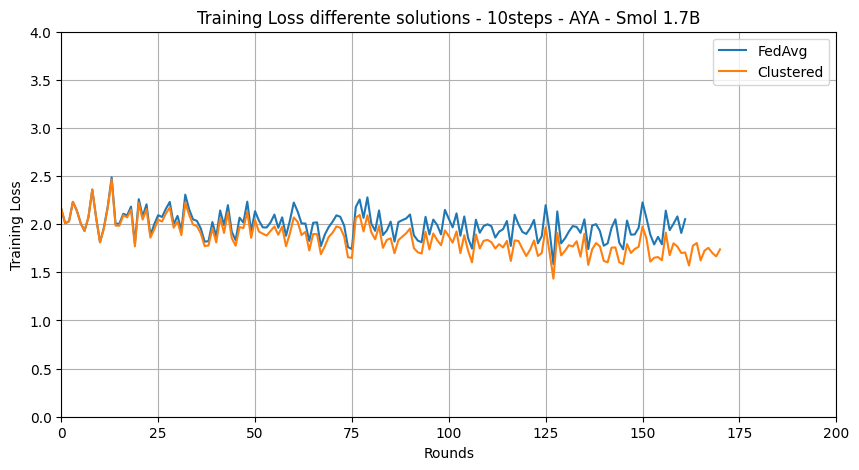

In [41]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-1.7B/aya_fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401095144/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-1.7B/aya_clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401095200/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

# Set overall title
plt.title('Training Loss differente solutions - 10steps - AYA - Smol 1.7B')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

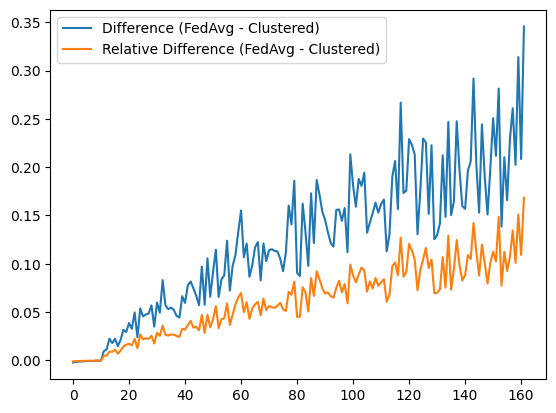

In [42]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/2355064113.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/2355064113.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/2355064113.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


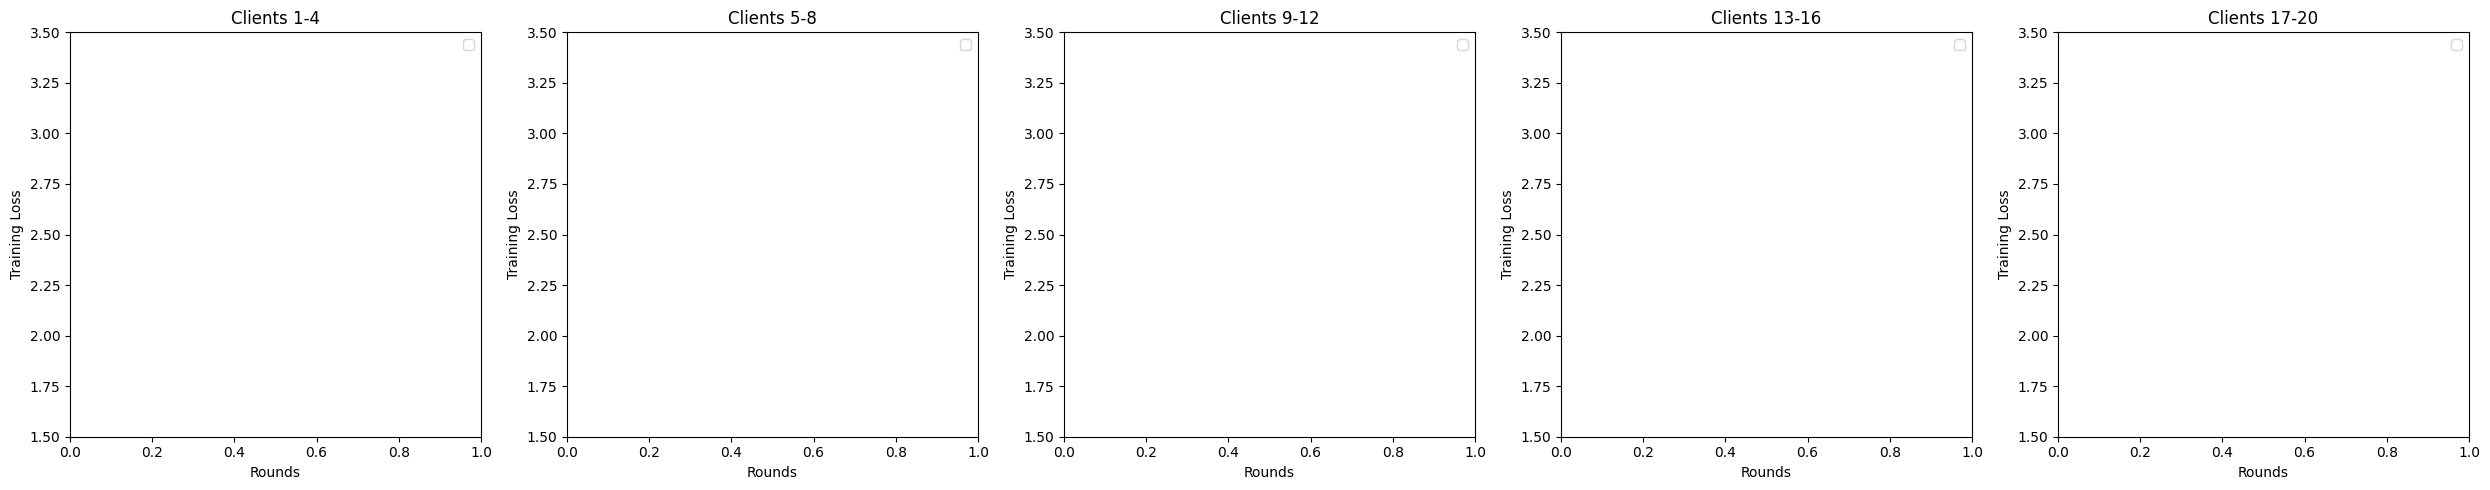

In [43]:
colors = sns.color_palette("tab10", 5)

# Load AYA data for FedAvg and Clustered solutions
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-1.7B/aya_fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401095144/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)

clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/SmolLM-1.7B/aya_clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401095200/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)

rounds = np.arange(data_fedavg.shape[1])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes):
    start = i * 4
    fedavg_subset = data_fedavg[start:start+4, :]
    clustered_subset = data_clustered[start:start+4, :]
    fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
    clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
    
    # Plot FedAvg (solid) and Clustered (dotted) in the same subplot
    #sns.lineplot(x=rounds, y=fedavg_mean, ax=ax, label=f'FedAvg Clients {start+1}-{start+4}',
    #             color=colors[i], linestyle='solid')
    #sns.lineplot(x=rounds, y=clustered_mean, ax=ax, label=f'Clustered Clients {start+1}-{start+4}',
    #             color=colors[i], linestyle='dotted')
    
    ax.set_title(f'Clients {start+1}-{start+4}')
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Training Loss')
    ax.set_ylim(1.5, 3.5)
    ax.legend()

plt.tight_layout()
plt.show()


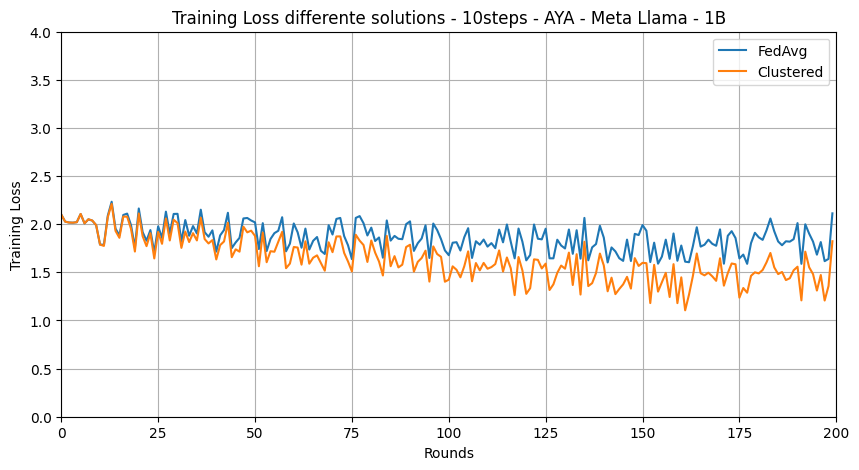

In [44]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401162934/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401163027/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg')
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered')

# Set overall title
plt.title('Training Loss differente solutions - 10steps - AYA - Meta Llama - 1B')
plt.xlabel('Rounds')
plt.ylabel('Training Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()

<Axes: >

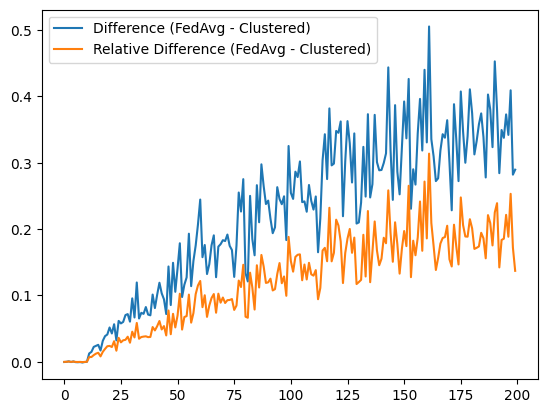

In [45]:
diff = []
relative_diff = []
for i in range(min(len(losses), len(losses2))):
    diff.append(losses[i] - losses2[i])
    relative_diff.append((losses[i] - losses2[i]) / losses[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)')
sns.lineplot(x=range(len(relative_diff)), y=relative_diff, label='Relative Difference (FedAvg - Clustered)')

/tmp/ipykernel_3137999/3657914952.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3657914952.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3657914952.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3657914952.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3657914952.py:17: RuntimeWarning: Mean of empty slice
  fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
/tmp/ipykernel_3137999/3657914952.py:18: RuntimeWarning: Mean of empty slice
  clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_su

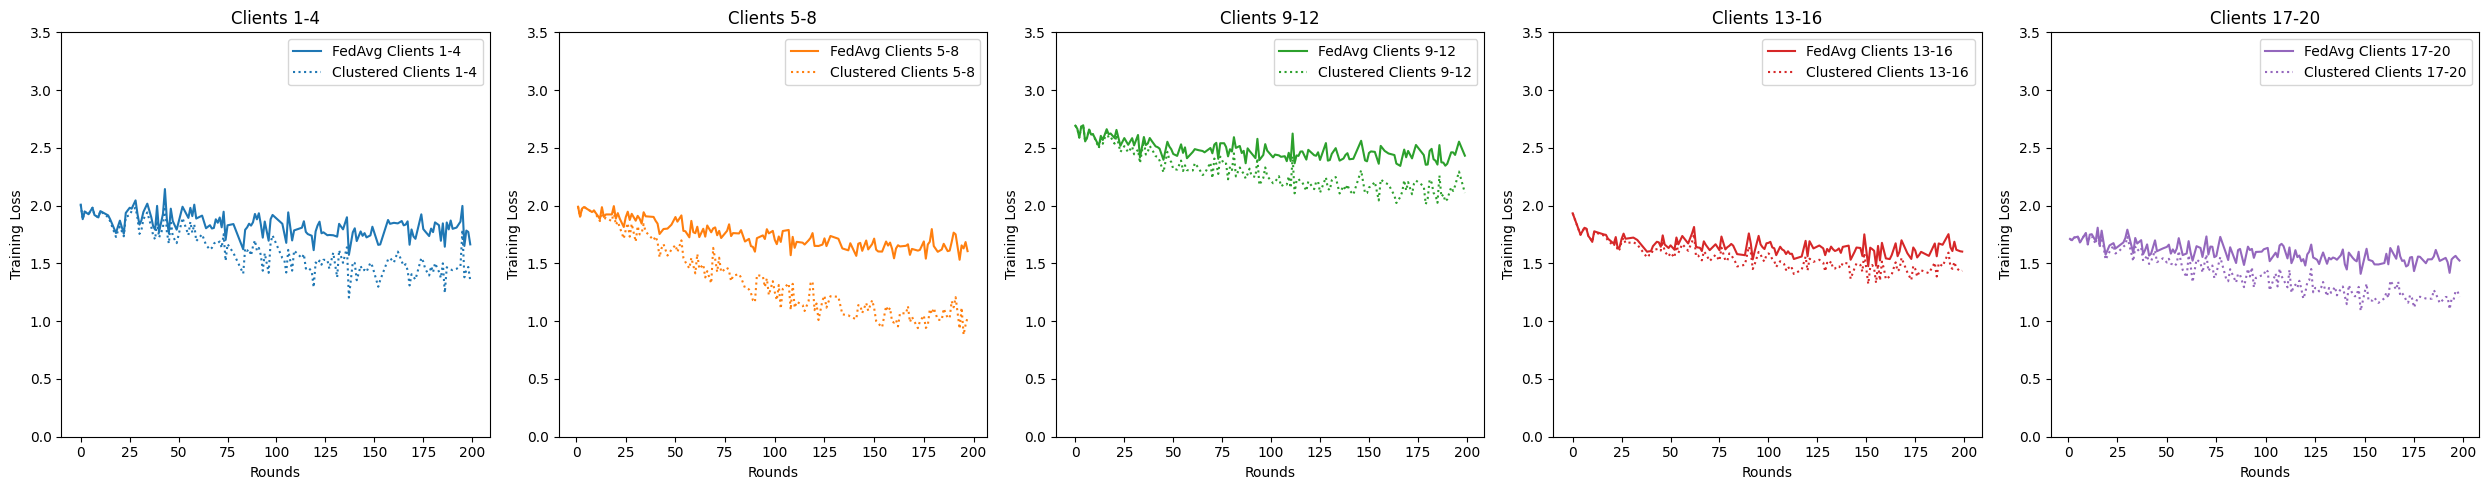

In [46]:
colors = sns.color_palette("tab10", 5)

# Load AYA data for FedAvg and Clustered solutions
fedavg_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401162934/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)

clustered_path = '/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401163027/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)

rounds = np.arange(data_fedavg.shape[1])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes):
    start = i * 4
    fedavg_subset = data_fedavg[start:start+4, :]
    clustered_subset = data_clustered[start:start+4, :]
    fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
    clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
    
    # Plot FedAvg (solid) and Clustered (dotted) in the same subplot
    sns.lineplot(x=rounds, y=fedavg_mean, ax=ax, label=f'FedAvg Clients {start+1}-{start+4}',
                 color=colors[i], linestyle='solid')
    sns.lineplot(x=rounds, y=clustered_mean, ax=ax, label=f'Clustered Clients {start+1}-{start+4}',
                 color=colors[i], linestyle='dotted')
    
    ax.set_title(f'Clients {start+1}-{start+4}')
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Training Loss')
    ax.set_ylim(0, 3.5)
    ax.legend()

plt.tight_layout()
plt.show()


<Axes: >

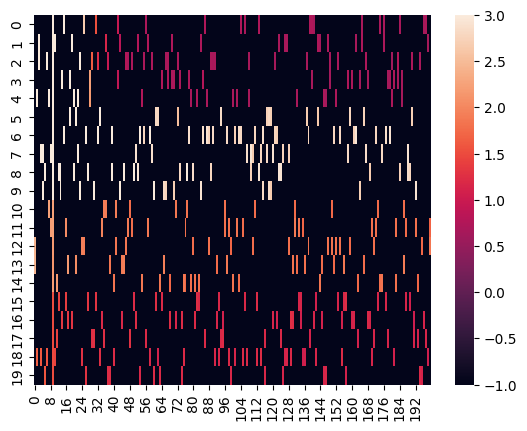

In [47]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/multitask_400000_clustered_c20s2_i10_b16a1_l1024_r8a16_20250324093735/training_loss.npy'
data = np.load(path, allow_pickle=True)
sns.heatmap(data, vmin=-1, vmax=3)

<Axes: >

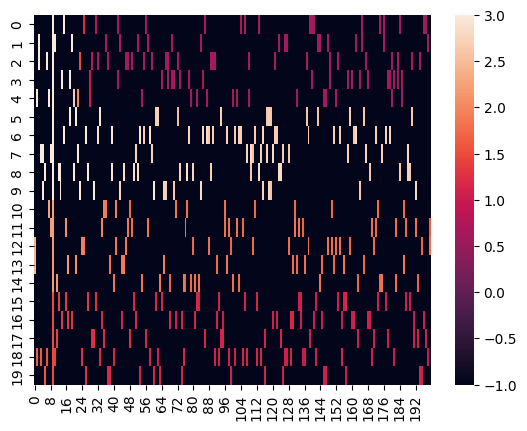

In [48]:
path = '/home/gabriel.talasso/FT_LLM_FL/output_multitask/multitask_400000_clustered_c20s2_i10_b16a1_l1024_r8a16_20250324093643/training_loss.npy'
data = np.load(path, allow_pickle=True)
sns.heatmap(data, vmin=-1, vmax=3)

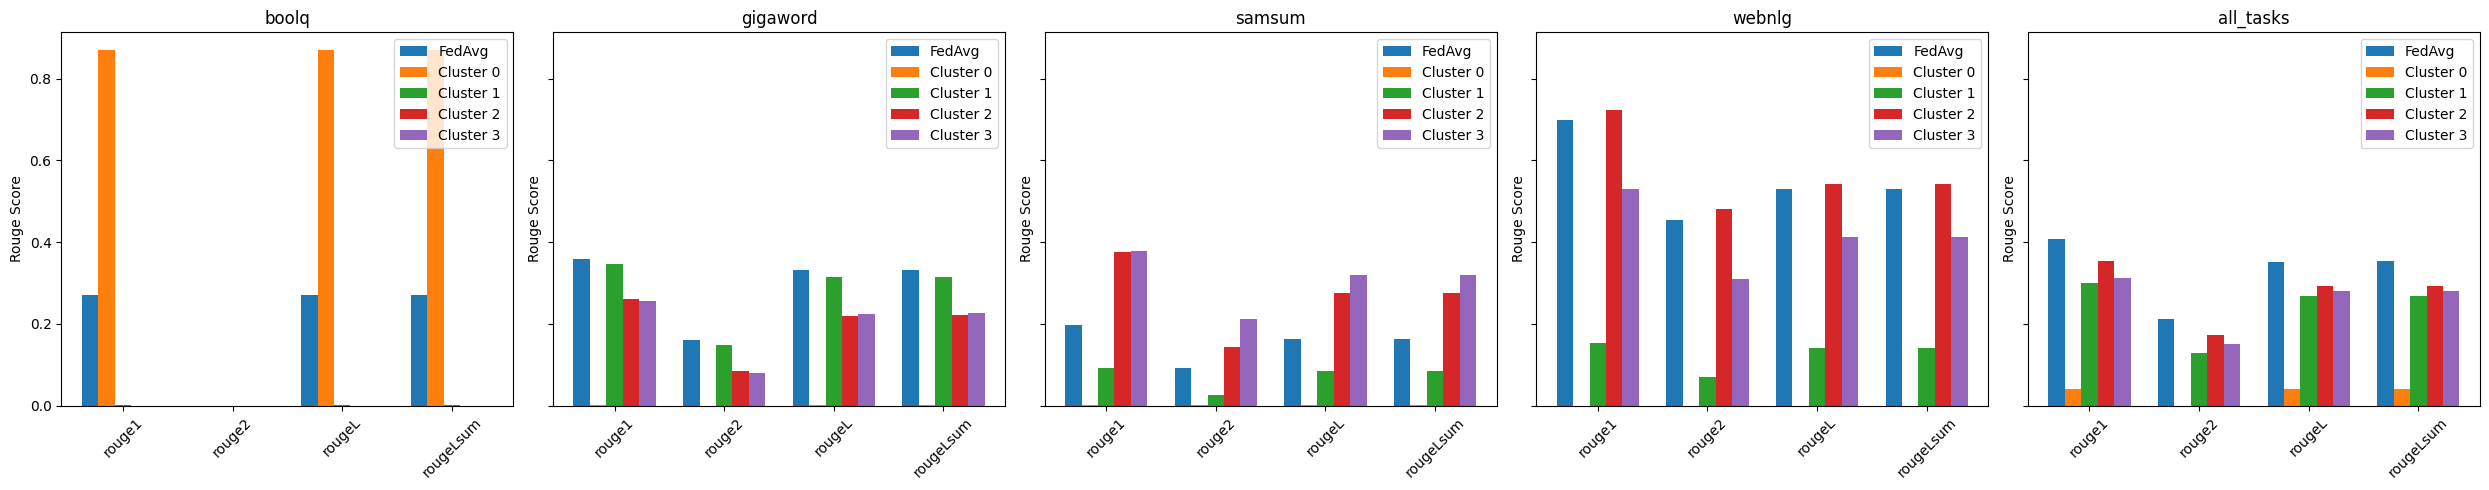

In [49]:
tasks = ['boolq', 'gigaword', 'samsum', 'webnlg', 'all_tasks']
round = 200
clusters = [0, 1, 2, 3]
model_name = 'Llama-3.2-1B'

path_fedavg = f'/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/fedavg_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401152254/cluster_0_checkpoint-{round}'

fig, axes = plt.subplots(1, len(tasks), figsize=(5 * len(tasks), 5), sharey=True)
if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    # Load FedAvg results for the task
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    fedavg_rouge = fedavg['rouge']

    # Load FedAvg dataset for the task
    dataset_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/responses/data-00000-of-00001.arrow'
    #print('Responses FedAvg', '------------------------------------------------------------')
    #dataset = datasets.arrow_dataset.Dataset.from_file(dataset_path)
    #print(dataset[0]['model_responses'])
    
    # Get the rouge metric keys (e.g., rouge1, rouge2, etc.)
    rouge_keys = list(fedavg_rouge.keys())
    
    # Prepare a list to hold values for each rouge metric.
    # Each element is a list with 5 values: FedAvg and one value per each cluster.
    rouge_values = []
    for rk in rouge_keys:
        group = [fedavg_rouge[rk]]
        # Iterate clusters for the current rouge metric
        for cluster in clusters:
            path_clustered = f'/home/gabriel.talasso/FT_LLM_FL/output_multitask/Llama-3.2-1B/clustered_multitask_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401151553'
            path_clustred_round = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
            dataset_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/responses/data-00000-of-00001.arrow'
            #print('Responses Clustered: ', cluster, '------------------------------------------------------------')
            #dataset = datasets.arrow_dataset.Dataset.from_file(dataset_path)
            #print(dataset[0]['model_responses'])

            clustered_results_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            group.append(clustered['rouge'][rk])
        rouge_values.append(group)

    # Plot grouped bar chart for this task
    x = np.arange(len(rouge_keys))  # positions for each rouge metric
    total_groups = 1 + len(clusters)  # FedAvg + each cluster (here 5)
    bar_width = 0.15

    labels = ['FedAvg'] + [f'Cluster {c}' for c in clusters]
    for i in range(total_groups):
        vals = [group[i] for group in rouge_values]
        ax.bar(x + i * bar_width, vals, width=bar_width, label=labels[i])
        
    ax.set_xticks(x + 2 * bar_width)
    ax.set_xticklabels(rouge_keys, rotation=45)
    ax.set_title(task)
    ax.set_ylabel('Rouge Score')
    ax.legend()

plt.tight_layout()
plt.show()

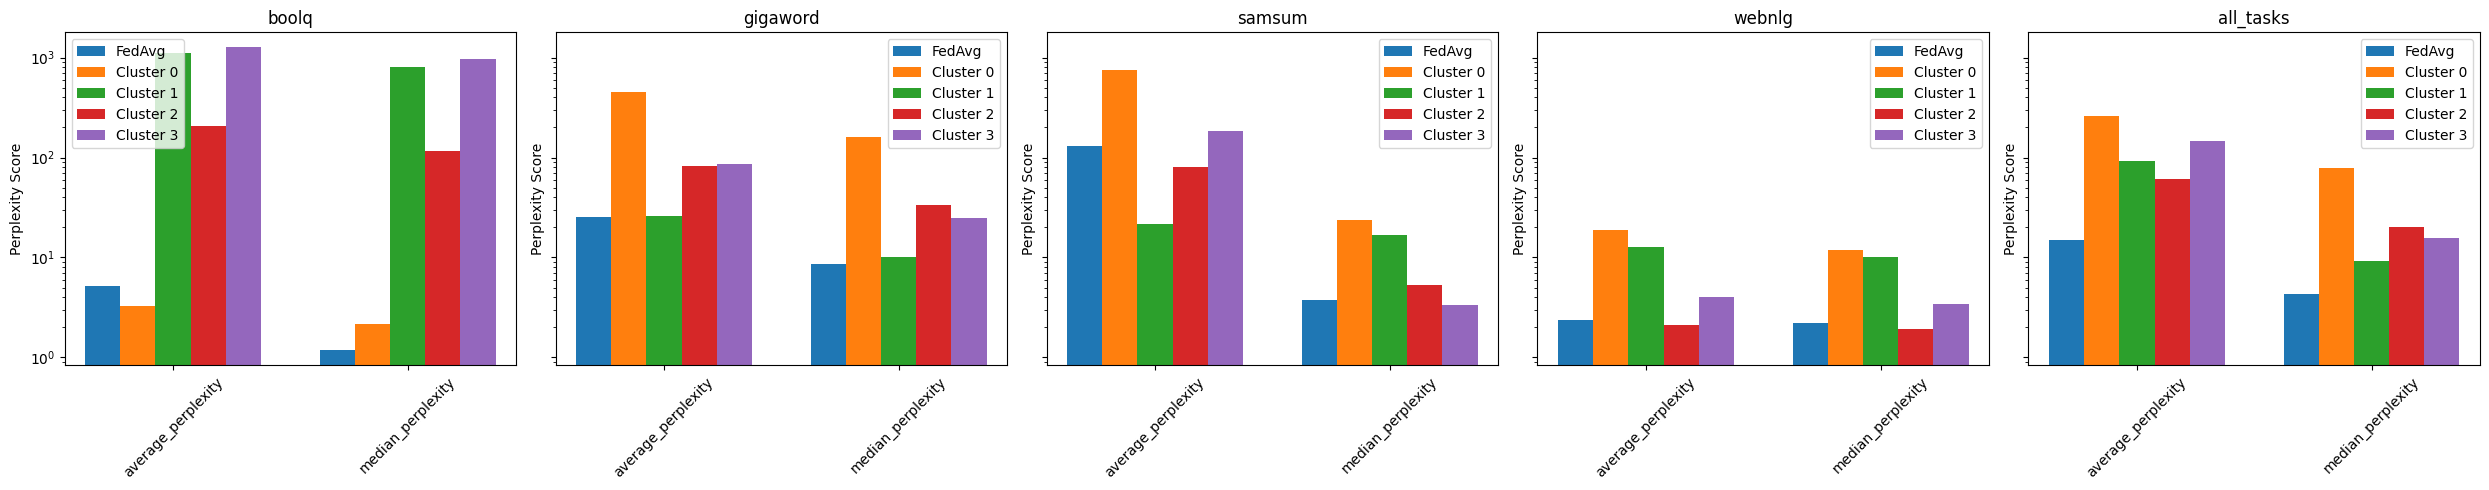

In [50]:
tasks = ['boolq', 'gigaword', 'samsum', 'webnlg', 'all_tasks']
round = 200
clusters = [0, 1, 2, 3]


fig, axes = plt.subplots(1, len(tasks), figsize=(5 * len(tasks), 5), sharey=True)
if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    # Load FedAvg results for the task
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    
    fedavg_perp = fedavg['perplexity']
    fedavg_rouge = {key: fedavg_perp[key] for key in ['average_perplexity','median_perplexity']}
    
    # Get the rouge metric keys (e.g., rouge1, rouge2, etc.)
    rouge_keys = list(fedavg_rouge.keys())
    
    # Prepare a list to hold values for each rouge metric.
    # Each element is a list with 5 values: FedAvg and one value per each cluster.
    rouge_values = []
    for rk in rouge_keys:
        group = [fedavg_rouge[rk]]
        # Iterate clusters for the current rouge metric
        for cluster in clusters:
            path_clustred_round = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
            clustered_results_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            group.append(clustered['perplexity'][rk])
        rouge_values.append(group)

    # Plot grouped bar chart for this task
    x = np.arange(len(rouge_keys))  # positions for each rouge metric
    total_groups = 1 + len(clusters)  # FedAvg + each cluster (here 5)
    bar_width = 0.15

    labels = ['FedAvg'] + [f'Cluster {c}' for c in clusters]
    for i in range(total_groups):
        vals = [group[i] for group in rouge_values]
        ax.bar(x + i * bar_width, vals, width=bar_width, label=labels[i])
        
    ax.set_xticks(x + 2 * bar_width)
    ax.set_xticklabels(rouge_keys, rotation=45)
    ax.set_title(task)
    ax.set_yscale('log')
    ax.set_ylabel('Perplexity Score')
    ax.legend()

plt.tight_layout()
plt.show()
    

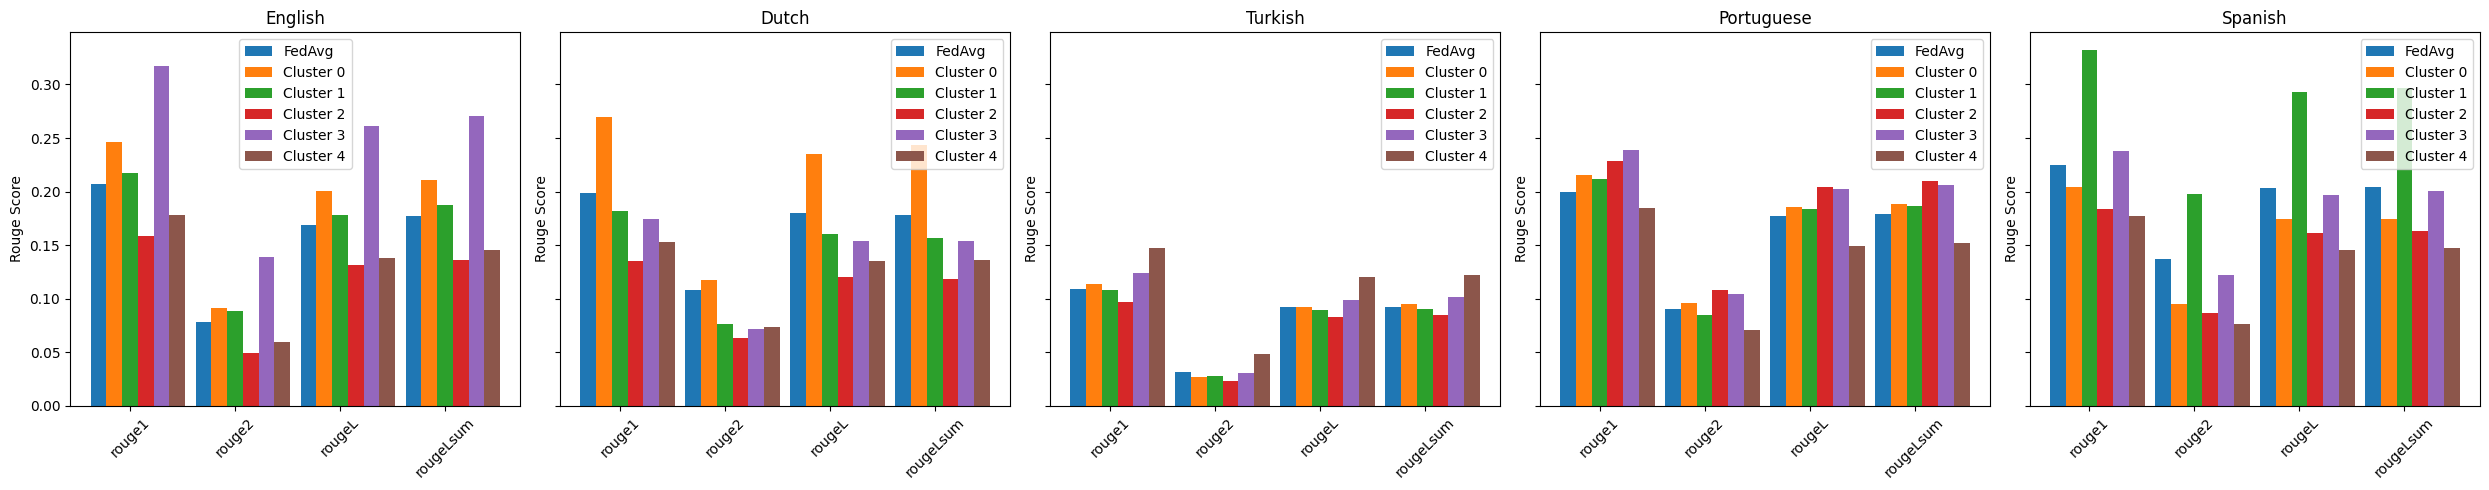

In [51]:
tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
round = 200
clusters = [0, 1, 2, 3, 4]
model_name = 'Llama-3.2-1B'

path_fedavg = f'/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/fedavg_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401162934/cluster_0_checkpoint-{round}'

fig, axes = plt.subplots(1, len(tasks), figsize=(5 * len(tasks), 5), sharey=True)
if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    # Load FedAvg results for the task
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    fedavg_rouge = fedavg['rouge']

    # Load FedAvg dataset for the task
    dataset_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/responses/data-00000-of-00001.arrow'
    #print('Responses FedAvg', '------------------------------------------------------------')
    #dataset = datasets.arrow_dataset.Dataset.from_file(dataset_path)
    #print(dataset[0]['model_responses'])
    
    # Get the rouge metric keys (e.g., rouge1, rouge2, etc.)
    rouge_keys = list(fedavg_rouge.keys())
    
    # Prepare a list to hold values for each rouge metric.
    # Each element is a list with 5 values: FedAvg and one value per each cluster.
    rouge_values = []
    for rk in rouge_keys:
        group = [fedavg_rouge[rk]]
        # Iterate clusters for the current rouge metric
        for cluster in clusters:
            path_clustered = f'/home/gabriel.talasso/FT_LLM_FL/output_aya/Llama-3.2-1B/clustered_aya_dataset_clustered_c20s5_i10_b16a1_l1024_r8a16_20250401163027'
            path_clustred_round = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
            dataset_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/responses/data-00000-of-00001.arrow'
            #print('Responses Clustered: ', cluster, '------------------------------------------------------------')
            #dataset = datasets.arrow_dataset.Dataset.from_file(dataset_path)
            #print(dataset[0]['model_responses'])

            clustered_results_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            group.append(clustered['rouge'][rk])
        rouge_values.append(group)

    # Plot grouped bar chart for this task
    x = np.arange(len(rouge_keys))  # positions for each rouge metric
    total_groups = 1 + len(clusters)  # FedAvg + each cluster (here 5)
    bar_width = 0.15

    labels = ['FedAvg'] + [f'Cluster {c}' for c in clusters]
    for i in range(total_groups):
        vals = [group[i] for group in rouge_values]
        ax.bar(x + i * bar_width, vals, width=bar_width, label=labels[i])
        
    ax.set_xticks(x + 2 * bar_width)
    ax.set_xticklabels(rouge_keys, rotation=45)
    ax.set_title(task)
    ax.set_ylabel('Rouge Score')
    ax.legend()

plt.tight_layout()
plt.show()

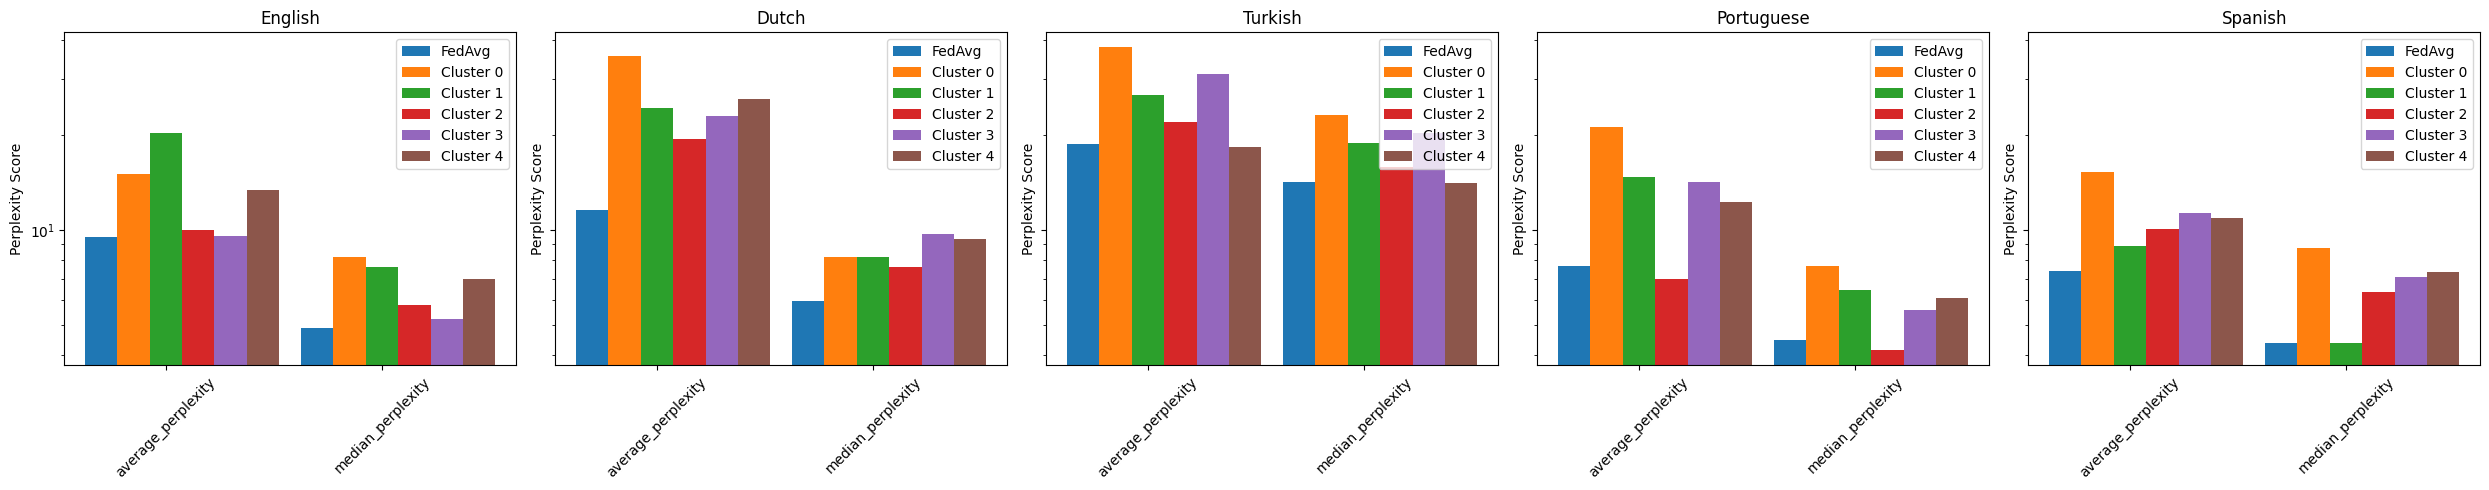

In [52]:
tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
round = 200
clusters = [0, 1, 2, 3, 4]
model_name = 'Llama-3.2-1B'


fig, axes = plt.subplots(1, len(tasks), figsize=(5 * len(tasks), 5), sharey=True)
if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    # Load FedAvg results for the task
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-200_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    
    fedavg_perp = fedavg['perplexity']
    fedavg_rouge = {key: fedavg_perp[key] for key in ['average_perplexity','median_perplexity']}
    
    # Get the rouge metric keys (e.g., rouge1, rouge2, etc.)
    rouge_keys = list(fedavg_rouge.keys())
    
    # Prepare a list to hold values for each rouge metric.
    # Each element is a list with 5 values: FedAvg and one value per each cluster.
    rouge_values = []
    for rk in rouge_keys:
        group = [fedavg_rouge[rk]]
        # Iterate clusters for the current rouge metric
        for cluster in clusters:
            path_clustred_round = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
            clustered_results_path = path_clustred_round + f'/cluster_{cluster}_checkpoint-200_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            group.append(clustered['perplexity'][rk])
        rouge_values.append(group)

    # Plot grouped bar chart for this task
    x = np.arange(len(rouge_keys))  # positions for each rouge metric
    total_groups = 1 + len(clusters)  # FedAvg + each cluster (here 5)
    bar_width = 0.15

    labels = ['FedAvg'] + [f'Cluster {c}' for c in clusters]
    for i in range(total_groups):
        vals = [group[i] for group in rouge_values]
        ax.bar(x + i * bar_width, vals, width=bar_width, label=labels[i])
        
    ax.set_xticks(x + 2 * bar_width)
    ax.set_xticklabels(rouge_keys, rotation=45)
    ax.set_title(task)
    ax.set_yscale('log')
    ax.set_ylabel('Perplexity Score')
    ax.legend()

plt.tight_layout()
plt.show()
    